# Content and Objectives

- Show spectral estimation of modulated signals incl. pulse shaping (rect and raised-cosine) for random data
- Spectra are determined based on the theoretical pulse shape as well as for the random signals when applying estimation

# Import

In [1]:
# importing
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib


In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=False)

matplotlib.rc('figure', figsize=(24, 10) )


# showing figures inline
%matplotlib inline

# Function for determining the impulse response of an RC filter

In [3]:
# find impulse response of an RC filter
def get_rc_ir(K, n_sps, t_symbol, beta):
    
    ''' 
    Determines coefficients of an RC filter 
    
    Formula out of: K.-D. Kammeyer, Nachrichtenübertragung
    At poles, l'Hospital was used 
    
    NOTE: Length of the IR has to be an odd number
    
    IN: length of IR, upsampling factor, symbol time, roll-off factor
    OUT: filter coefficients
    '''

    # check that IR length is odd
    assert K % 2 == 1, 'Length of the impulse response should be an odd number'
    
    # map zero r to close-to-zero
    if beta == 0:
        beta = 1e-32


    # initialize output length and sample time
    rc = np.zeros( K )
    t_sample = t_symbol / n_sps
    
    
    # time indices and sampled time
    k_steps = np.arange( -(K-1) / 2.0, (K-1) / 2.0 + 1 )   
    t_steps = k_steps * t_sample
    
    for k in k_steps.astype(int):
        
        if t_steps[k] == 0:
            rc[ k ] = 1. / t_symbol
            
        elif np.abs( t_steps[k] ) == t_symbol / ( 2.0 * beta ):
            rc[ k ] = beta / ( 2.0 * t_symbol ) * np.sin( np.pi / ( 2.0 * beta ) )
            
        else:
            rc[ k ] = np.sin( np.pi * t_steps[k] / t_symbol ) / np.pi / t_steps[k] \
                * np.cos( beta * np.pi * t_steps[k] / t_symbol ) \
                / ( 1.0 - ( 2.0 * beta * t_steps[k] / t_symbol )**2 )
 
    return rc

# Parameters

In [4]:
# modulation scheme and constellation points
M = 2
constellation_points = [ -1, 1 ]

# symbol time and number of symbols    
t_symb = 1.0
n_symb = int( 1e5 )
 

# parameters of the RRC filter
beta = .33

n_sps = 8            # samples per symbol
t_sample = t_symb / n_sps

syms_per_filt = 4  # symbols per filter (plus minus in both directions)

K_filt = 2 * syms_per_filt * n_sps + 1         # length of the fir filter


# parameters for frequency regime
N_fft = 512
Omega = np.linspace( -np.pi, np.pi, N_fft)
f_vec = Omega / ( 2 * np.pi * t_symb / n_sps )

# Signals and their spectra

In [5]:
# get RC pulse and rectangular pulse,
# both being normalized to energy 1
rc = get_rc_ir( K_filt, n_sps, t_symb, beta )
rc /= np.linalg.norm( rc ) 

rect = np.append( np.ones( n_sps ), np.zeros( len( rc ) - n_sps ) )
rect /= np.linalg.norm( rect )


# get pulse spectra
RC_PSD = np.abs( np.fft.fftshift( np.fft.fft( rc, N_fft ) ) )**2
RC_PSD /= n_sps

RECT_PSD = np.abs( np.fft.fftshift( np.fft.fft( rect, N_fft ) ) )**2
RECT_PSD /= n_sps


# Real data-modulated Tx-signal

+ NOTE: Here, we are using linear modulation (BPSK)
+ Please note the according results for OOK and PPM when discussing those methods

### Option 1: use FFT and average along several realizations

In [6]:
# number of realizations along which to average the psd estimate
n_real = 100

# initialize two-dimensional field for collecting several realizations along which to average 
S_rc = np.zeros( (n_real, N_fft ), dtype=complex ) 
S_rect = np.zeros( (n_real, N_fft ), dtype=complex )


# loop for multiple realizations in order to improve spectral estimation
for k in range( n_real ):

    # generate random binary vector and 
    # modulate the specified modulation scheme
    data = np.random.randint( M, size = n_symb )
    s = [ constellation_points[ d ] for d in data ]

    # alternatively
    s = np.random.choice( constellation_points, size = n_symb, p = (.5, .5 ) )

    # apply RC filtering/pulse-shaping
    s_up_rc = np.zeros( n_symb * n_sps )        
    s_up_rc[ : : n_sps ] = s

    s_rc = np.convolve( rc, s_up_rc)

    
    # apply RECTANGULAR filtering/pulse-shaping
    s_up_rect = np.zeros( n_symb * n_sps )      
    s_up_rect[ : : n_sps ] = s

    s_rect = np.convolve( rect, s_up_rect)        

    
    # get spectrum using Bartlett method
    S_rc[k, :] = np.fft.fftshift( np.fft.fft( s_rc, N_fft ) )
    S_rect[k, :] = np.fft.fftshift( np.fft.fft( s_rect, N_fft ) )


# average along realizations
RC_PSD_sim = np.average( np.abs( S_rc )**2, axis=0 )
RC_PSD_sim /= np.max( RC_PSD_sim )

RECT_PSD_sim = np.average( np.abs( S_rect )**2, axis=0 ) 
RECT_PSD_sim /= np.max( RECT_PSD_sim )

### Option 2: Use "on-board" methods for spetral estimation

In [7]:
# alternatively
s = np.random.choice( constellation_points, size = n_symb, p = (.25, .75 ) )

# apply RC filtering/pulse-shaping
s_up_rc = np.zeros( n_symb * n_sps )        
s_up_rc[ : : n_sps ] = s
s_rc = np.convolve( rc, s_up_rc)

f_rc, S_RC = signal.welch( s_rc, 1/t_sample, nperseg=1024 ) 
S_RC /= np.max( np.abs( S_RC ) )

# apply RECTANGULAR filtering/pulse-shaping
s_up_rect = np.zeros( n_symb * n_sps )      
s_up_rect[ : : n_sps ] = s
s_rect = np.convolve( rect, s_up_rect)     

f_rect, S_RECT = signal.welch( s_rect, 1/t_sample, nperseg=1024 ) 
S_RECT /= np.max( np.abs( S_RECT ) )

# Plotting

### Signal and Spectrum

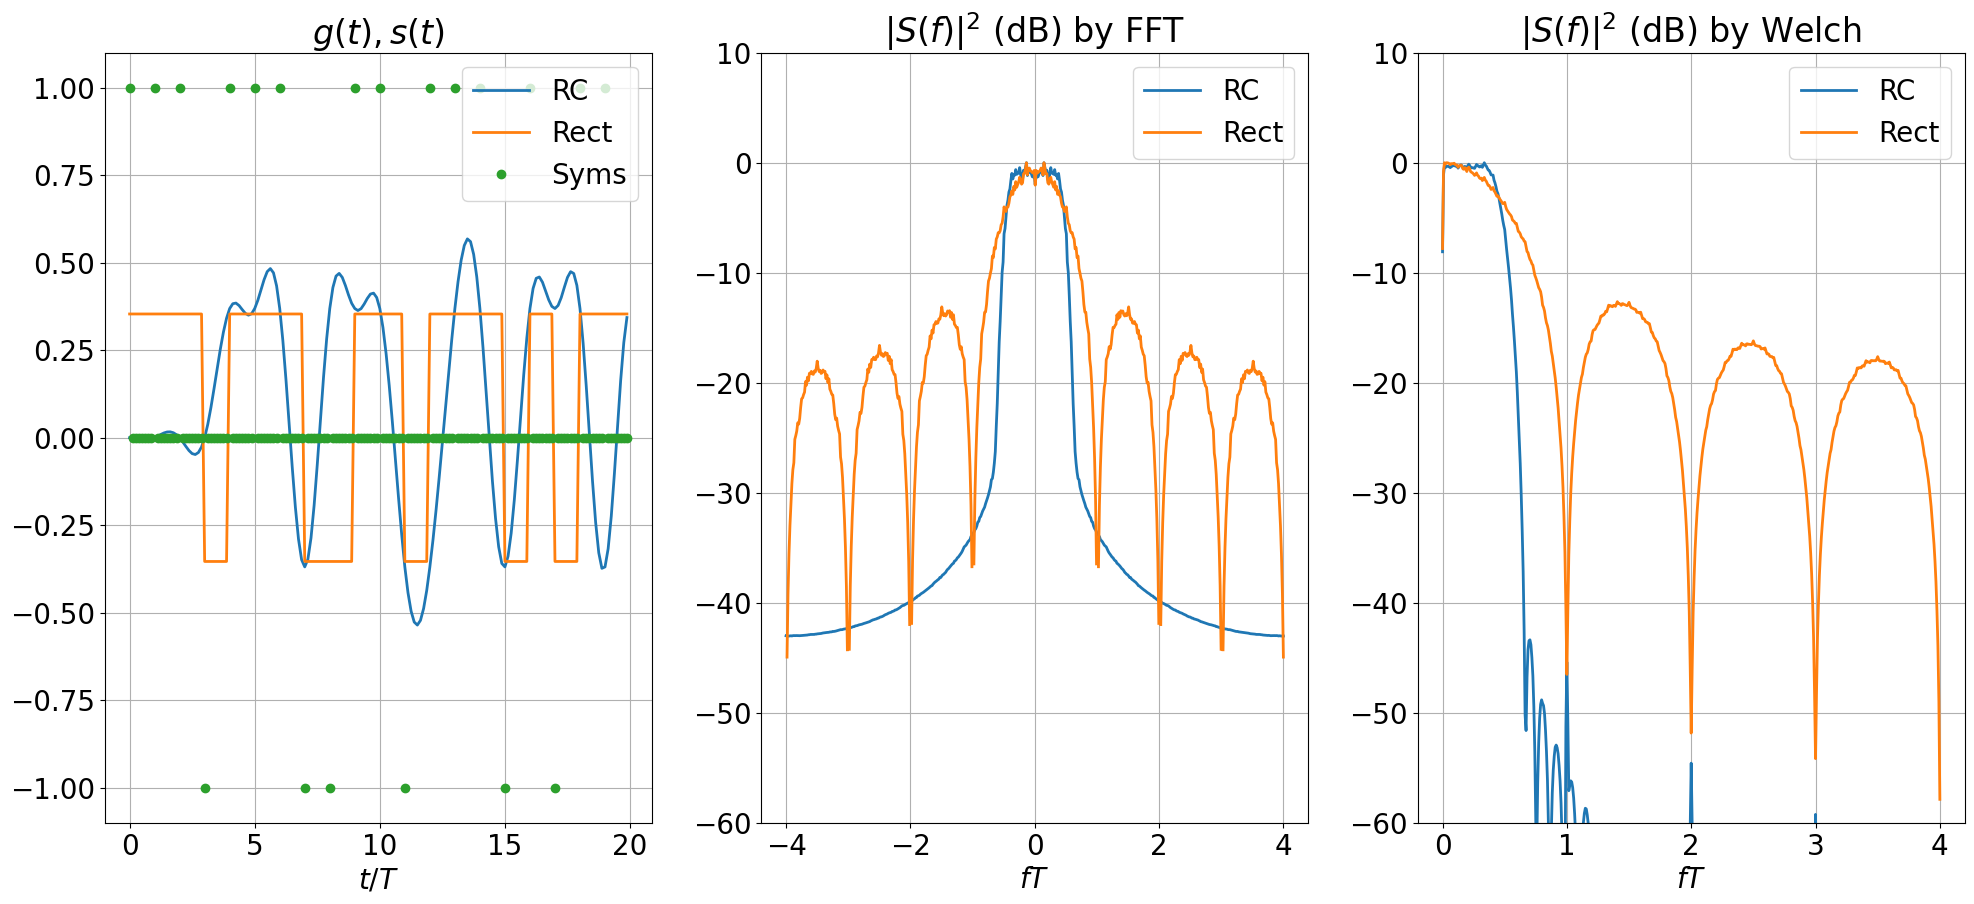

In [8]:
plt.subplot(131)

# upper limit for number of symbols shown in the plot
ul = 20 * n_sps
plt.plot( np.arange( np.size( s_rc[ : ul ])) * t_symb / n_sps, s_rc[ : ul ], linewidth=2.0, label='RC' )
plt.plot( np.arange( np.size( s_rect[ : ul ])) * t_symb / n_sps, s_rect[ : ul ], linewidth=2.0, label='Rect' )   
plt.plot( np.arange( np.size( s_up_rc[ : ul ])) * t_symb / n_sps, s_up_rc[ : ul ], 'o', linewidth=2.0, label='Syms' )

plt.ylim( (-1.1, 1.1 ) )
plt.grid(True)    
plt.legend(loc='upper right')    
plt.title( '$g(t), s(t)$' )

plt.xlabel('$t/T$')


plt.subplot(132)
np.seterr(divide='ignore') # ignore warning for logarithm of 0
plt.plot( f_vec, 10*np.log10( RC_PSD_sim ), linewidth=2.0, label='RC' )
plt.plot( f_vec, 10*np.log10( RECT_PSD_sim ), linewidth=2.0, label='Rect' ) 
np.seterr(divide='warn') # enable warning for logarithm of 0

plt.grid(True); 
plt.xlabel('$fT$');  
plt.legend(loc='upper right')
plt.title( '$|S(f)|^2$ (dB) by FFT' )    
plt.ylim( (-60, 10 ) )


plt.subplot(133)
np.seterr(divide='ignore') # ignore warning for logarithm of 0
plt.plot( f_rc, 10*np.log10( S_RC ), linewidth=2.0, label='RC' )
plt.plot( f_rect, 10*np.log10( S_RECT ), linewidth=2.0, label='Rect' ) 
np.seterr(divide='warn') # enable warning for logarithm of 0

plt.grid(True); 
plt.xlabel('$fT$');  
plt.legend(loc='upper right')
plt.title( '$|S(f)|^2$ (dB) by Welch' )    
plt.ylim( (-60, 10 ) )

plt.show()

### Signal and Spectrum, but linear amplitude of spectrum

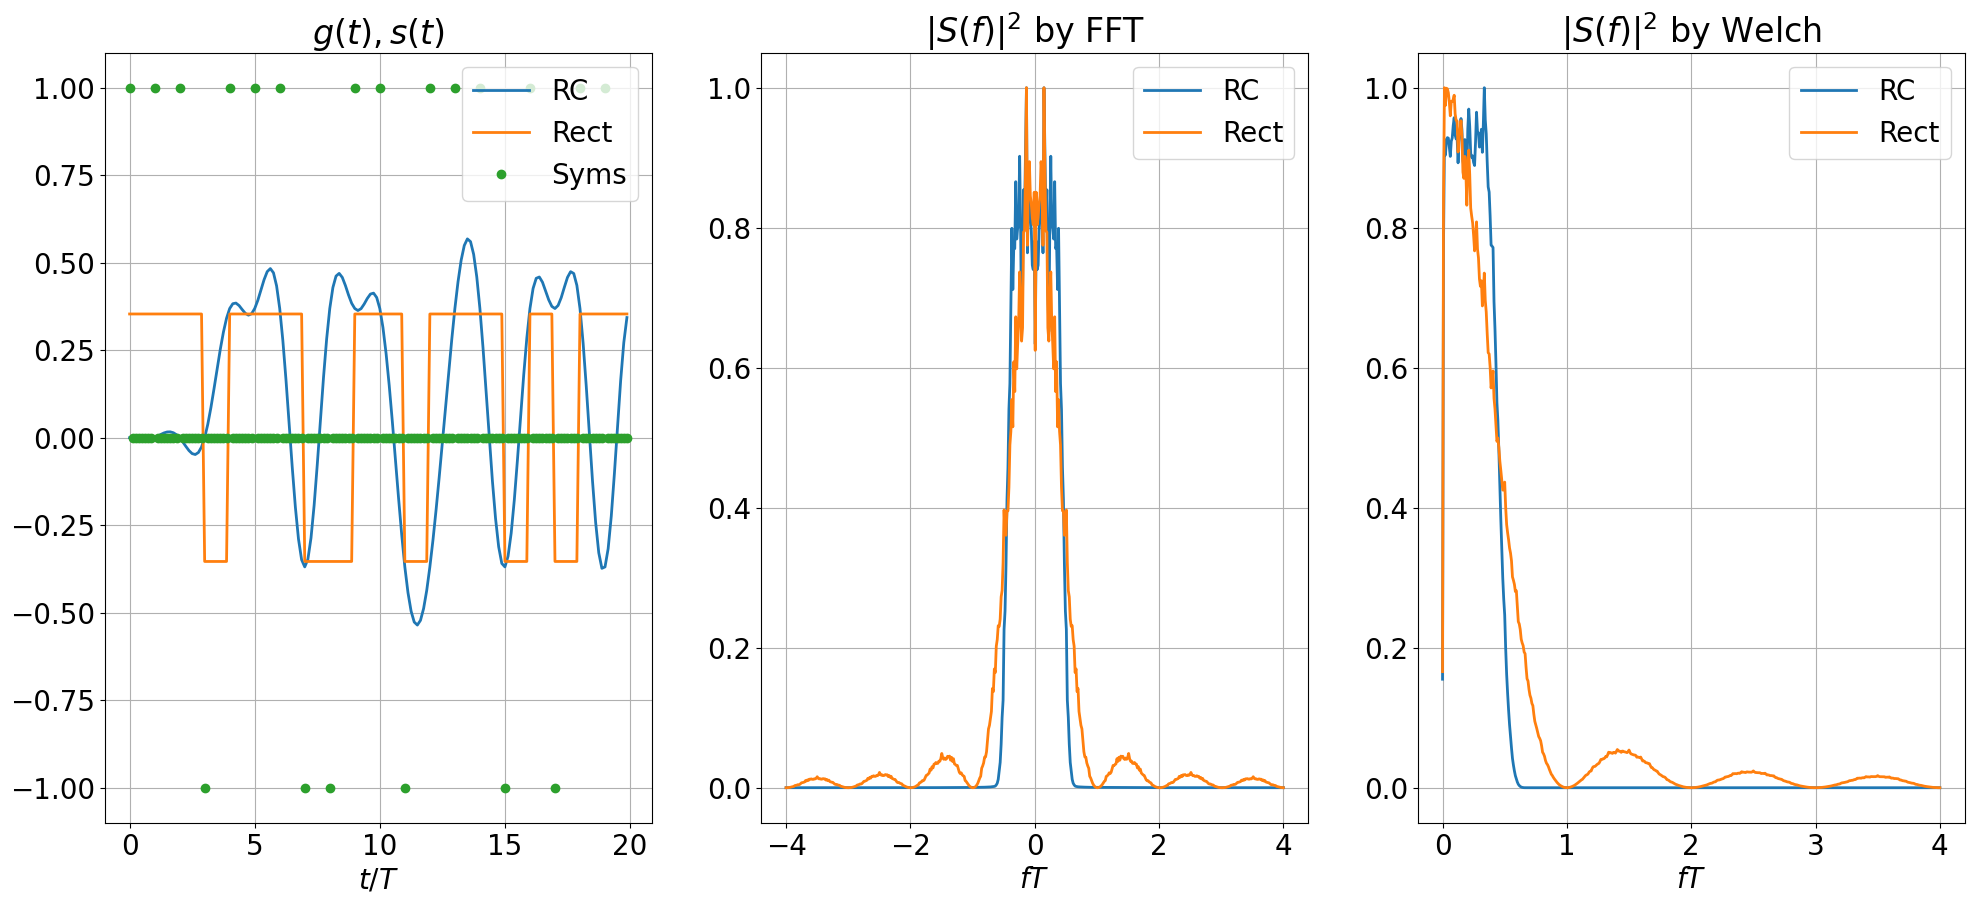

In [9]:
plt.subplot(131)

# upper limit for number of symbols shown in the plot
ul = 20 * n_sps
plt.plot( np.arange( np.size( s_rc[ : ul ])) * t_symb / n_sps, s_rc[ : ul ], linewidth=2.0, label='RC' )
plt.plot( np.arange( np.size( s_rect[ : ul ])) * t_symb / n_sps, s_rect[ : ul ], linewidth=2.0, label='Rect' )   
plt.plot( np.arange( np.size( s_up_rc[ : ul ])) * t_symb / n_sps, s_up_rc[ : ul ], 'o', linewidth=2.0, label='Syms' )

plt.ylim( (-1.1, 1.1 ) )
plt.grid(True)    
plt.legend(loc='upper right')    
plt.title( '$g(t), s(t)$' )

plt.xlabel('$t/T$')


plt.subplot(132)
plt.plot( f_vec, RC_PSD_sim, linewidth=2.0, label='RC' )
plt.plot( f_vec, RECT_PSD_sim, linewidth=2.0, label='Rect' ) 
np.seterr(divide='warn') # enable warning for logarithm of 0

plt.grid(True); 
plt.xlabel('$fT$');  
plt.legend(loc='upper right')
plt.title( '$|S(f)|^2$ by FFT' )    


plt.subplot(133)
np.seterr(divide='ignore') # ignore warning for logarithm of 0
plt.plot( f_rc,  S_RC, linewidth=2.0, label='RC' )
plt.plot( f_rect, S_RECT, linewidth=2.0, label='Rect' ) 

plt.grid(True); 
plt.xlabel('$fT$');  
plt.legend(loc='upper right')
plt.title( '$|S(f)|^2$ by Welch' )    


plt.show()

# Waterfall Diagram

+ If signal characteristics change with time, it might make sense to use spectral estimation that is "local" in time
+ Examples: Short-Time FFT -> apply FFT to windows and shot segment-wise spectra

### Show it for FSK first

In [10]:
# set parameter for all schemes
T_pulse = 1

# samples-per-smbol
n_sps = 128

# time vector per pulse
t_per_pulse = np.linspace( 0, T_pulse, n_sps )
t_sample = T_pulse / n_sps

# parameters of the RRC filter
# design is chosen such that interval length equals 6 sigma
pulse = np.ones( n_sps )
pulse /= np.linalg.norm( pulse )

# NOTE: to illustrate phase deltas, an artificial carrier frequency if applied
f_c = 2

# number of symbols within the signal
n_symb = 1000

# number of symbols shown in the time signal
n_shown = 3

In [11]:
# number of PPM indices, log2 of which corresponds to bits
M_FSK = 2

# delta_f for FSP
delta_f = 2
f_c = 10

# duration of pulse and symbol
T = T_pulse 

# total time for all n_symb symbols
t_FSK_total = np.linspace( 0, ( n_symb + 1 ) * T, n_sps * n_symb )

In [12]:
# bits to be transmitted
b = np.random.randint( M_FSK, size=n_symb )
b_antipodal = 1 - 2 * b

# construct signal
s_FSK_copy_paste  = np.zeros( n_symb * n_sps, dtype=complex )
for _n in range( n_symb ):
    s_FSK_copy_paste[ _n * n_sps : ( _n + 1 ) * n_sps ] = np.exp( 1j * 2 * np.pi * delta_f * b_antipodal[ _n ] * t_per_pulse )

s_FSK_bandpass = np.real( s_FSK_copy_paste * np.exp( 1j * 2 * np.pi * f_c * t_FSK_total ) )

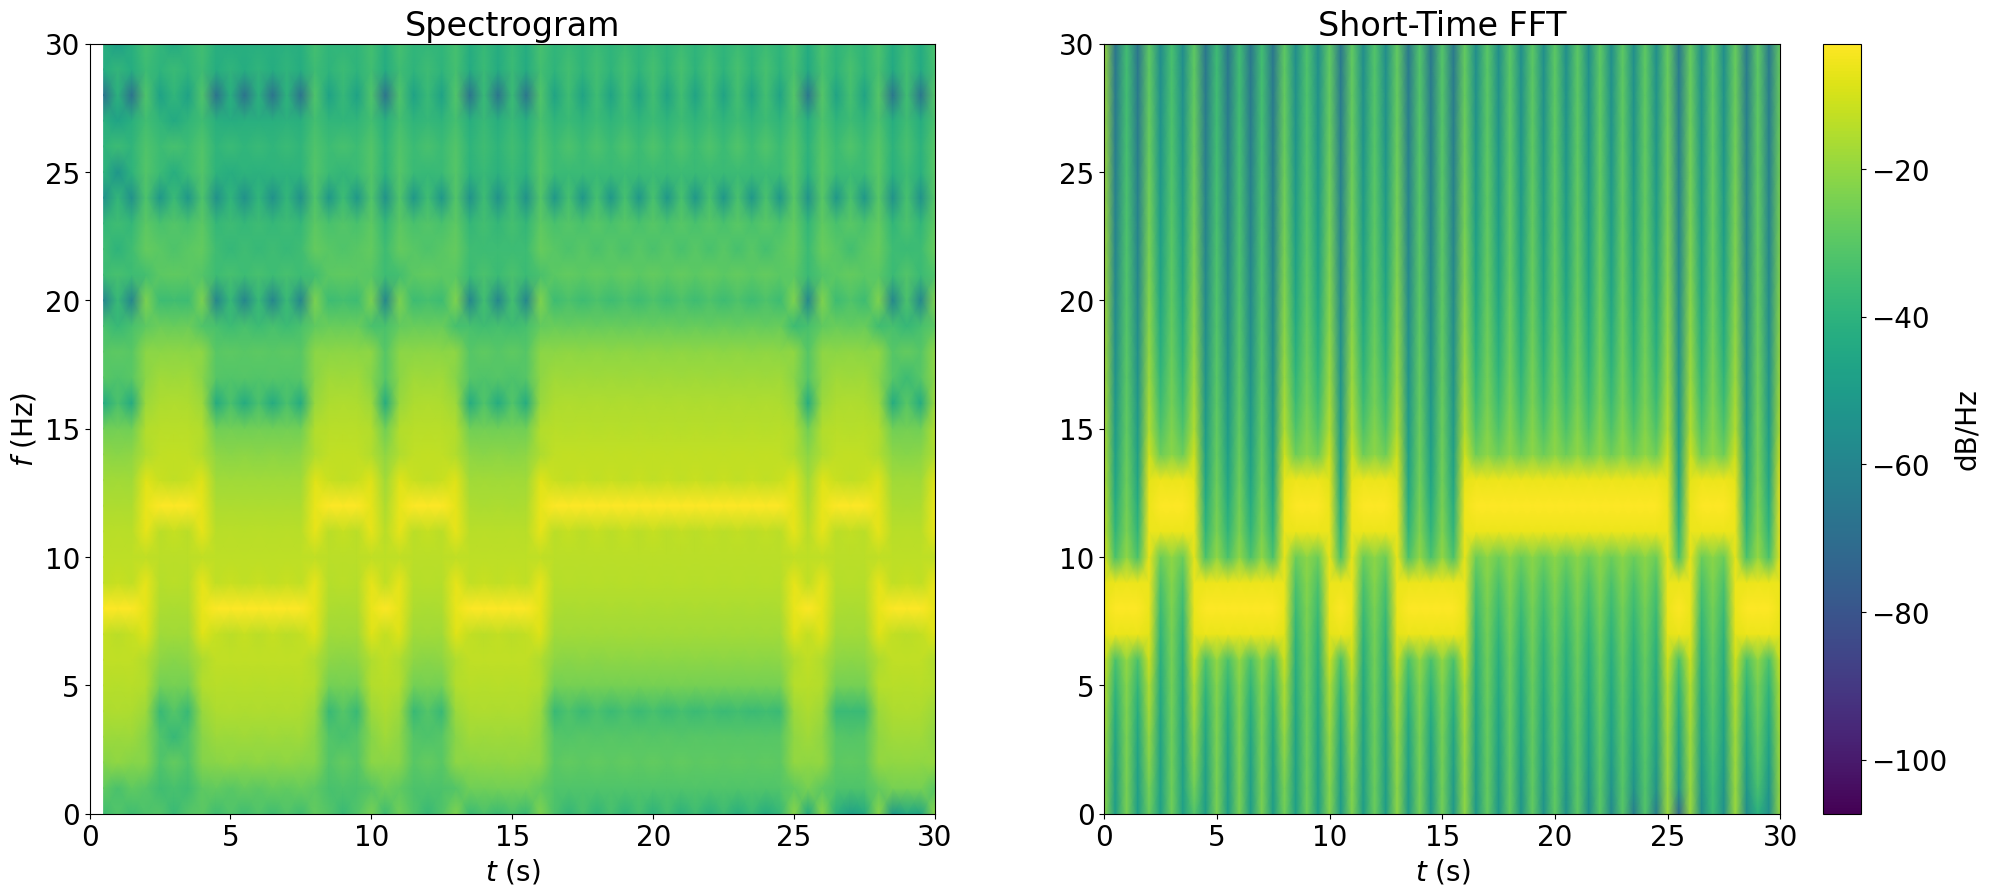

In [13]:

# spectrogram to observe spectrum over time
f_spectro, t_spectro, S_FSK_spectro = signal.spectrogram( s_FSK_bandpass, fs=1/t_sample, nperseg=n_sps, noverlap=n_sps/2)
f_stfft, t_stfft, S_FSK_stfft = signal.stft( s_FSK_bandpass , fs=1/t_sample, nperseg=n_sps, noverlap=n_sps/2)


plt.figure()

plt.subplot(121)
plt.pcolormesh( t_spectro, f_spectro, 10 * np.log10( S_FSK_spectro ), shading='gouraud' )
# plt.colorbar(label="dB/Hz")
plt.xlabel("$t$ (s)")
plt.ylabel("$f$ (Hz)")
plt.title("Spectrogram")
plt.xlim( (0, 30))
plt.ylim( (0, 30))

plt.subplot(122)
plt.pcolormesh( t_stfft, f_stfft, 10 * np.log10( np.abs( S_FSK_stfft ) ), shading='gouraud' )
plt.colorbar(label="dB/Hz")
plt.xlabel("$t$ (s)")
# plt.ylabel("$f$ (Hz)")
plt.title("Short-Time FFT")
plt.xlim( (0, 30))
plt.ylim( (0, 30))

plt.show()


### Now check waterfall for the RC signal

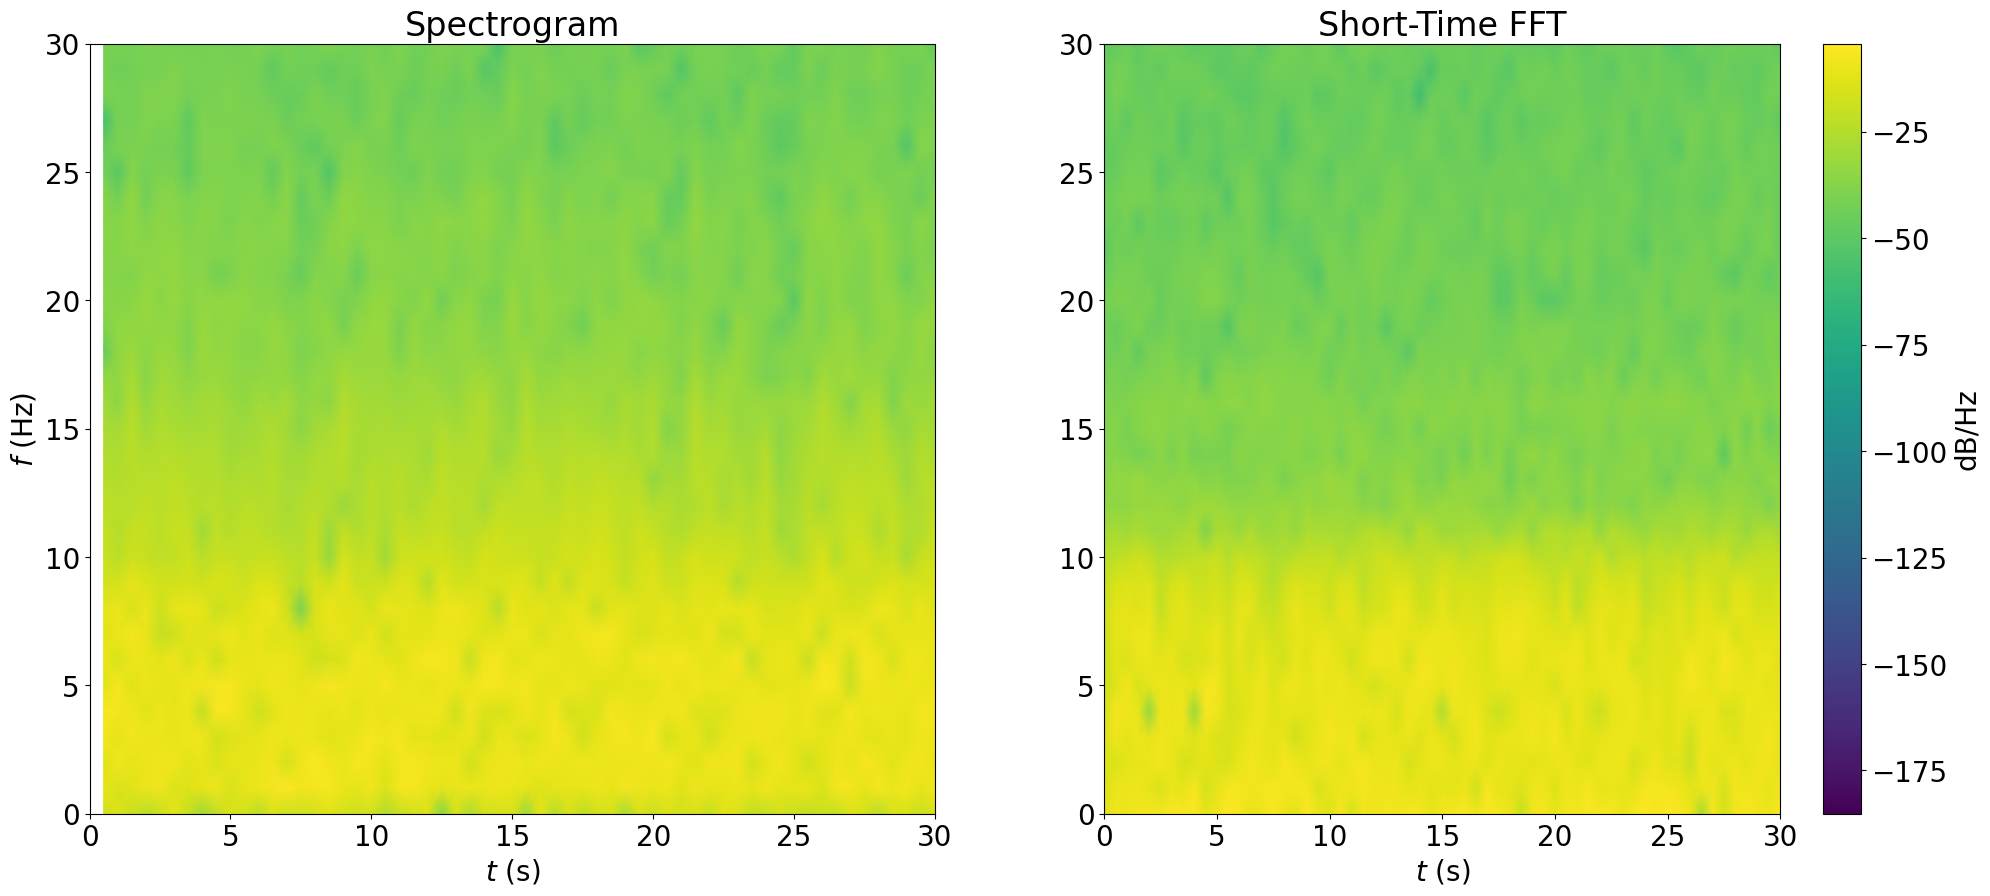

In [14]:

# spectrogram to observe spectrum over time
f_spectro, t_spectro, S_FSK_spectro = signal.spectrogram( s_rc, fs=1/t_sample, nperseg=n_sps, noverlap=n_sps/2)
f_stfft, t_stfft, S_FSK_stfft = signal.stft( s_rc , fs=1/t_sample, nperseg=n_sps, noverlap=n_sps/2)


plt.figure()

plt.subplot(121)
plt.pcolormesh( t_spectro, f_spectro, 10 * np.log10( S_FSK_spectro ), shading='gouraud' )
# plt.colorbar(label="dB/Hz")
plt.xlabel("$t$ (s)")
plt.ylabel("$f$ (Hz)")
plt.title("Spectrogram")
plt.xlim( (0, 30))
plt.ylim( (0, 30))

plt.subplot(122)
plt.pcolormesh( t_stfft, f_stfft, 10 * np.log10( np.abs( S_FSK_stfft ) ), shading='gouraud' )
plt.colorbar(label="dB/Hz")
plt.xlabel("$t$ (s)")
# plt.ylabel("$f$ (Hz)")
plt.title("Short-Time FFT")
plt.xlim( (0, 30))
plt.ylim( (0, 30))

plt.show()
